# Importing Libraries and Cleaned Datasets

In [153]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as sm
import scipy.stats as stats
from sklearn.feature_selection import mutual_info_regression
import warnings
warnings.filterwarnings('ignore')

county_health_rank = pd.read_csv('county_rankings25.csv')
qol_22 = pd.read_csv('QOL.csv')
gini = pd.read_csv('gini_index.csv')
fips_codes = pd.read_csv('all_fips.csv')
county_vars = pd.read_csv('county_vars_2.csv')
race_groups = pd.read_csv('agg_race_variables.csv')

# Data Cleaning Plan
## County Health Rankings 2025
In place of the previousl 4 tables reporting socio economic metrics, I found a new Dataset 'County Health Rankings.' The data wrangling process will involve selecting the target variables, renaming, normalizing data types, validating the resulting dataframe, and applying the standardized hierarchical index (county, state).

Since dataset contains hundreds of variables, I created a small dataframe of our variables of interest and normalized names to facilate creating the subset itself and its naming conventions. 

Note: much of the numeric data is in percentages, separate subsets will include totals and percentages and will be used depnding on type of analysis and indexing needed.

## FIPS & States ID table
I will merge both tables above to a previosly created 'all_fips' (which serves as a sort of  'fact table'-listing county names, state names, state abbreviations, and corresponding fips codes) by index. 

I will validate the data and clean any merging errors like the creation of duplicate columns and/or changes to naming conventions (such as adding suffixes/prefixes to duplicate and original colums).

Finally, I will merge both of these new tables by the standardized index mentioned above.

# Data Cleaning

## County Rankings tables

### Make Subset Function

In [154]:
# defining variable for function to select target vars, dictionary to rename, and set 'fips' as 'str' dtype
county_health_subset = county_vars['raw_variable'].tolist()
county_name_list = county_vars[' new_name'].tolist()
county_new_names = dict(zip(county_health_subset, county_name_list))

In [155]:
def make_subset(df, target_vars, target_names):
    df = df[target_vars]
    df = df.rename(columns=target_names) #dictionary defined from target variables & names list
    df['fips'] = df['fips'].astype('str')
    return df

In [156]:
counties = make_subset(county_health_rank, county_health_subset, county_new_names)

### Clean colums function

In [157]:
# list of state names from master fips to drop from county namers column
state_names = fips_codes['state'].unique()
state_names = state_names.tolist()
state_names.append('United States')
# variable name referring to state 
def clean_subset(df):
    df = df[~df['county'].isin(state_names)]
    df = df.round(2)
    return df

In [158]:
counties = clean_subset(counties)

## Gini

In [159]:
gini_target_vars = ['fips', 'county', 'state', 'gini_index']
gini_new_names = {'gini_index':'gini_ind'}

In [160]:
gini = make_subset(gini, gini_target_vars, gini_new_names)
gini = clean_subset(gini)

### QOL- Political Party 2020

In [161]:
qol_target_vars = ['2020PopulrVoteParty', 'NMCNTY', 'FIPS', 'LSTATE']
qol_new_names = {'2020PopulrVoteParty': 'political_party', 'NMCNTY':'county', 'FIPS':'fips', 'LSTATE':'state_abbr'}

In [162]:
pol_party_2020 = make_subset(qol_22, qol_target_vars, qol_new_names)

## subsets and groupings for drill-down analysis 

## Variable-based subsets

In [163]:
inequity_vars = ['state_abbr','county','fips', 'income_inequality', 'gender_pay_gap', 'school_segration_index', 'residential_segregation','school_funding_gap']
# Socio-economic indicators with racial breakdown
racial_category_subset = race_groups['raw_variable'].tolist()
racial_category_names = race_groups['new_name'].tolist()
racial_category_cols = dict(zip(racial_category_subset, racial_category_names))

In [164]:
# cleaning and reshaping dataframe with variable containing racial-breakdowns
race_subset = make_subset(county_health_rank, racial_category_subset, racial_category_cols)
counties_race = clean_subset(race_subset)
# reshape dataframe
# Melt the dataframe to long format
counties_race = counties_race.melt(
    id_vars=['state_abbr', 'county', 'fips', 'county_population'], 
    var_name='metric_race', 
    value_name='value'
)

# Split the combined 'metric_ethnicity' column
counties_race[['metric', 'race']] = counties_race['metric_race'].str.extract(r'(.+?)-(.+)')

# Drop the original combined column
counties_race = counties_race.drop(columns='metric_race')

# Pivot to have metrics as columns
counties_race = counties_race.pivot_table(
    index=['state_abbr', 'county', 'fips', 'race', 'county_population'],
    columns='metric',
    values='value'
).reset_index()

# Clean up column names if needed
counties_race.columns.name = None

### County-Level socio-economic outcomes (no racial breakdown)

In [165]:
aggregate_outcomes = counties.drop(columns=['income_inequality', 'gender_pay_gap', 'school_segration_index', 'residential_segregation','school_funding_gap', 'child_mortality', 'child_poverty_percentage', 'firearm_fatalities',
       'life_expectancy', 'median_income', 'premature_death'])

## Total Values (vs percentages)

In [166]:
pop_vars = ['state_abbr','county','fips', 'population']
county_pop = counties[pop_vars]
# find columns w percentage ouputs by assigining target string to variable ans using lamda  func to filter col names and assign to list
percent_str = 'percentage'
percent_vars = list(filter(lambda x: percent_str in x, county_name_list))
counties_totals = counties.copy()
counties_pop_col = 'population'

#### totals function

In [167]:
# multiplies each percentage column by county polulation to yield total amounts
def calc_total_pop(df, cols, pop_col):
    for i in df[cols]:
        df[i] = df[i] * df[pop_col]
    df.columns = df.columns.str.replace('_percentage', '')
    return df

In [168]:
counties_totals= clean_subset(counties_totals)

### Totals- broken down by race

In [169]:
race_pop_col = 'county_population'
race_percentage_vars = [ 'population_percentage', 'child_poverty_percentage']
racial_breakdown_total = counties_race.copy()

In [170]:
counties_race_totals = calc_total_pop(racial_breakdown_total, race_percentage_vars, race_pop_col)

Note: Many missing values

## Merge for Analysis

In [171]:
fips_codes['fips'] = fips_codes['fips'].astype('str')
index = ['state_abbr', 'county', 'fips']

In [172]:
gini.reset_index(inplace=True)#state
fips_codes.reset_index(inplace=True)
pol_party_2020.reset_index(inplace=True) #state_abbr
counties.reset_index(inplace=True) #state_abbr
# setting common indices

### Merge dataframes using 'state' with 'fact' table ('all_fips') and set indices for uniform id variables

In [ ]:
fips_codes.set_index(index)
pol_party_2020.set_index(index)
counties.set_index(index)
pol_party_indexed = pd.merge(pol_party_2020, fips_codes, on=index, how='inner')
counties_indexed = pd.merge(counties, fips_codes, on=index, how='inner')

### Merge counties and pol_party df's on common multi-index

In [174]:
index_2 = ['state', 'state_abbr', 'county', 'fips']
counties_indexed.reset_index()
pol_party_indexed.reset_index()

,index,index_x,political_party,county,fips,state_abbr,index_y,state
0,0,0,D,Charles City County,51036,VA,2824,Virginia
1,1,1,R,McMullen County,48311,TX,2678,Texas
2,2,2,R,Terrell County,48443,TX,2744,Texas
3,3,3,R,Skagway Municipality,2230,AK,22,Alaska
4,4,4,D,Baker County,13007,GA,390,Georgia
...,...,...,...,...,...,...,...,...
3127,3127,3129,D,Orange County,6059,CA,215,California
3128,3128,3130,D,Maricopa County,4013,AZ,178,Arizona
3129,3129,3131,R,Harris County,48201,TX,2623,Texas
3130,3130,3132,D,Cook County,17031,IL,709,Illinois


In [175]:
counties_indexed.set_index(index_2, inplace=True)
pol_party_indexed.set_index(index_2, inplace=True)
counties_pol_party = pd.merge(counties_indexed, pol_party_indexed, on=index_2, how='inner')

In [187]:
counties_pol_party.reset_index(inplace=True)

In [189]:
# function to clean merged tables
def clean_merged(df):
    # Drop duplicate rows in column: 'fips'
    df = df.drop_duplicates(subset='fips')
    df = df[~df['county'].isin(state_names)]
    df = df.round(3)
    return df


In [192]:
counties_pol_party = clean_merged(counties_pol_party)

In [194]:
def clean_extra_indices(df):
    # Drop columns: 'index_x_x', 'index_y_x' and 2 other columns
    df = testing.drop(columns=['index_x_x', 'index_y_x', 'index_x_y', 'index_y_y'])
    return df

In [195]:
pol_party_counties = clean_extra_indices(counties_pol_party.copy())
pol_party_counties.head()

,state,state_abbr,county,fips,hs_diploma_percentage,unemployed_percentage,population,median_income,school_segration_index,gender_pay_gap,...,residential_segregation,premature_death,income_inequality,child_poverty_percentage,life_expectancy,child_mortality,high_housing_cost_percentage,firearm_fatalities,child_care_cost_burden,political_party
0,Alabama,AL,Autauga County,1001,0.90,0.02,60342.0,68857.0,0.06,0.71,...,33.96,9938.26,4.27,0.17,74.80,61.26,0.12,17.45,0.22,R
1,Alabama,AL,Baldwin County,1003,0.92,0.02,253507.0,74248.0,0.09,0.72,...,42.65,8957.11,4.36,0.14,76.58,50.16,0.10,14.96,0.19,R
2,Alabama,AL,Barbour County,1005,0.78,0.04,24585.0,45298.0,0.04,0.77,...,22.73,12738.66,5.61,0.35,72.71,71.71,0.10,26.65,0.29,R
3,Alabama,AL,Bibb County,1007,0.80,0.02,21868.0,56025.0,0.09,0.82,...,40.01,11708.95,5.35,0.21,72.98,87.08,0.09,21.54,0.27,R
4,Alabama,AL,Blount County,1009,0.83,0.02,59816.0,64962.0,0.09,0.81,...,64.89,11898.09,4.62,0.17,72.94,58.04,0.08,18.14,0.25,R


# Insights

## Standardizing and preparing for variable selection

In [ ]:
independent_vars = ['income_inequality', 'gender_pay_gap',
       'school_segration_index', 'residential_segregation',
       'school_funding_gap']

dependent_vars = ['hs_diploma_percentage', 'unemployed_percentage', 'population', 'median_income', 'uninsured__percentage', 'premature_death', 'child_poverty_percentage', 'life_expectancy', 'child_mortality', 'high_housing_cost_percentage', 'firearm_fatalities', 'child_care_cost_burden']
vars_to_z = independent_vars + dependent_vars
#standardize_frame = counties[vars_to_z]
standardized_frame = counties.dropna()

In [214]:
# multiplies each percentage column by county polulation to yield total amounts
def calc_z(df, cols):
    for i in df[cols]:
        df[i] = np.abs(stats.zscore(df[i])) 
    return df


In [218]:
z_counties = calc_z(standardized_frame, vars_to_z)

## Mutual Information: finding highly dependent Vartiables

### Creating a Matrix of pairs fo each dependent var w independent var

In [220]:
# Initialize a matrix to store mutual information
mutual_info_matrix = np.zeros((len(independent_vars), len(dependent_vars)))

# Calculate mutual information for each independent-dependent variable pair
for i, var1 in enumerate(independent_vars):
    for j, var2 in enumerate(dependent_vars):
        X = z_counties[[var1]]
        y = z_counties[var2]
        mutual_info = mutual_info_regression(X, y)
        mutual_info_matrix[i, j] = mutual_info[0]  # Store the mutual info scalar

# Convert the matrix to a DataFrame for easier viewing
mutual_info_df = pd.DataFrame(mutual_info_matrix, index=independent_vars, columns=dependent_vars)

# Display the mutual information DataFrame
print(mutual_info_df)


                         hs_diploma_percentage  unemployed_percentage  \
income_inequality                     0.056166               0.047891   
gender_pay_gap                        0.000000               0.000000   
school_segration_index                0.000000               0.000000   
residential_segregation               0.012413               0.004979   
school_funding_gap                    0.023108               0.023963   

                         population  median_income  uninsured__percentage  \
income_inequality          0.020005       0.037363               0.007693   
gender_pay_gap             0.040246       0.000000               0.001554   
school_segration_index     0.085762       0.018397               0.035946   
residential_segregation    0.053964       0.000000               0.013622   
school_funding_gap         0.056167       0.030704               0.017487   

                         premature_death  child_poverty_percentage  \
income_inequality           

### Visualizing Pairwise Mutual Information as Heatmap

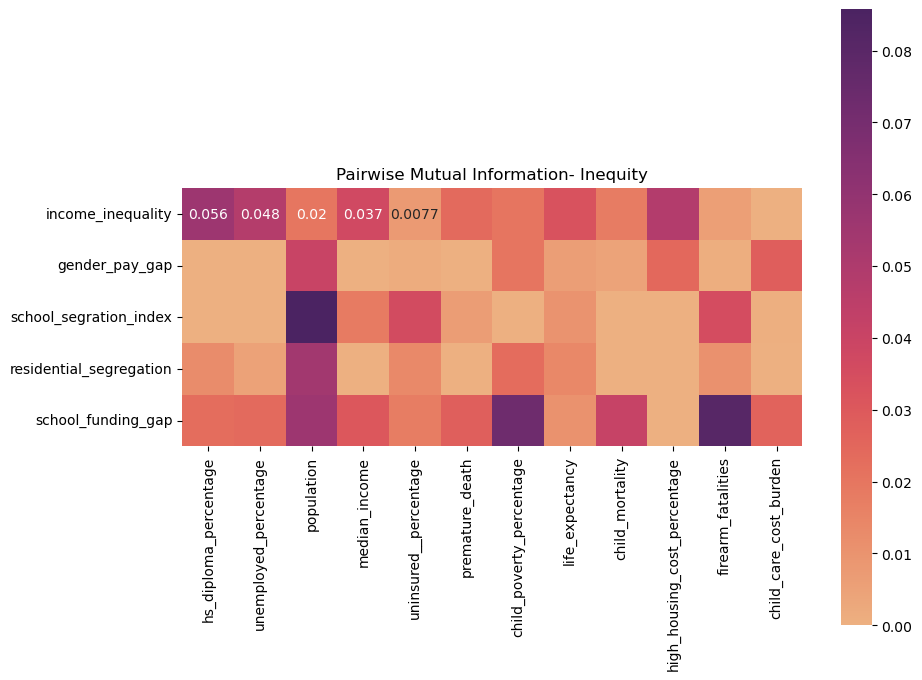

In [222]:
plt.figure(figsize=(10, 8))
sns.heatmap(mutual_info_df, annot=True, cmap='flare', square=True)
plt.title('Pairwise Mutual Information- Inequity')
plt.show()

### Getting top values of dependent pairs

In [224]:
top_var_pairs = mutual_info_df.unstack().sort_values(ascending=False).head(15)
print(top_var_pairs)

population                    school_segration_index     0.085762
firearm_fatalities            school_funding_gap         0.081222
child_poverty_percentage      school_funding_gap         0.072820
population                    school_funding_gap         0.056167
hs_diploma_percentage         income_inequality          0.056166
population                    residential_segregation    0.053964
high_housing_cost_percentage  income_inequality          0.048034
unemployed_percentage         income_inequality          0.047891
child_mortality               school_funding_gap         0.041361
population                    gender_pay_gap             0.040246
median_income                 income_inequality          0.037363
uninsured__percentage         school_segration_index     0.035946
firearm_fatalities            school_segration_index     0.035475
life_expectancy               income_inequality          0.033086
median_income                 school_funding_gap         0.030704
dtype: flo

### Data Description

In [ ]:
z_counties.describe()

<bound method NDFrame.describe of       index   fips             county state_abbr  hs_diploma_percentage  \
0         2   1001     Autauga County         AL               0.817253   
1         3   1003     Baldwin County         AL               0.156267   
2         4   1005     Barbour County         AL               2.245461   
3         5   1007        Bibb County         AL               1.584476   
4         6   1009      Blount County         AL               0.592997   
...     ...    ...                ...        ...                    ...   
3128   3181  56001      Albany County         WY               1.496197   
3134   3187  56013     Fremont County         WY               0.504719   
3138   3191  56021     Laramie County         WY               0.504719   
3140   3193  56025     Natrona County         WY               0.504719   
3146   3199  56037  Sweetwater County         WY               0.174226   

      unemployed_percentage  population  median_income  \
0      

### Correlation and Covariance

<Axes: >

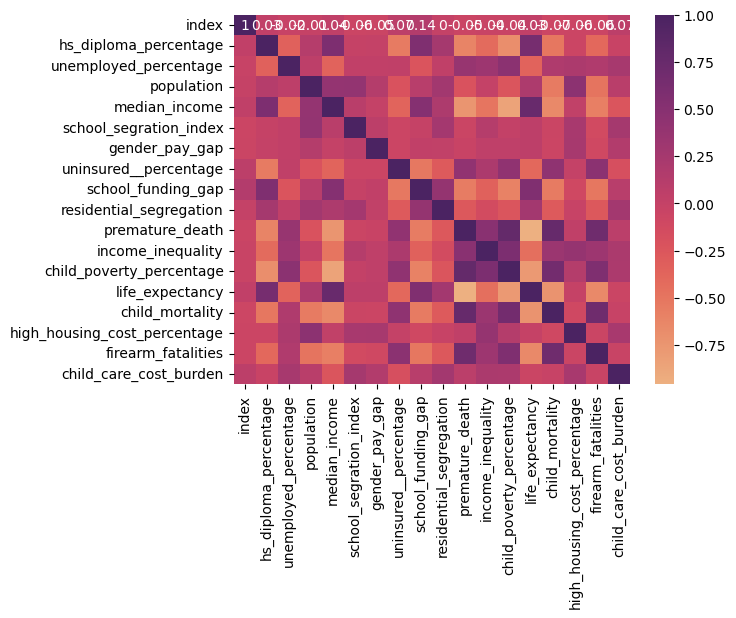

In [231]:
matrix = counties.corr(method='spearman', numeric_only=True).round(2)
sns.heatmap(matrix, annot=True, cmap='flare')

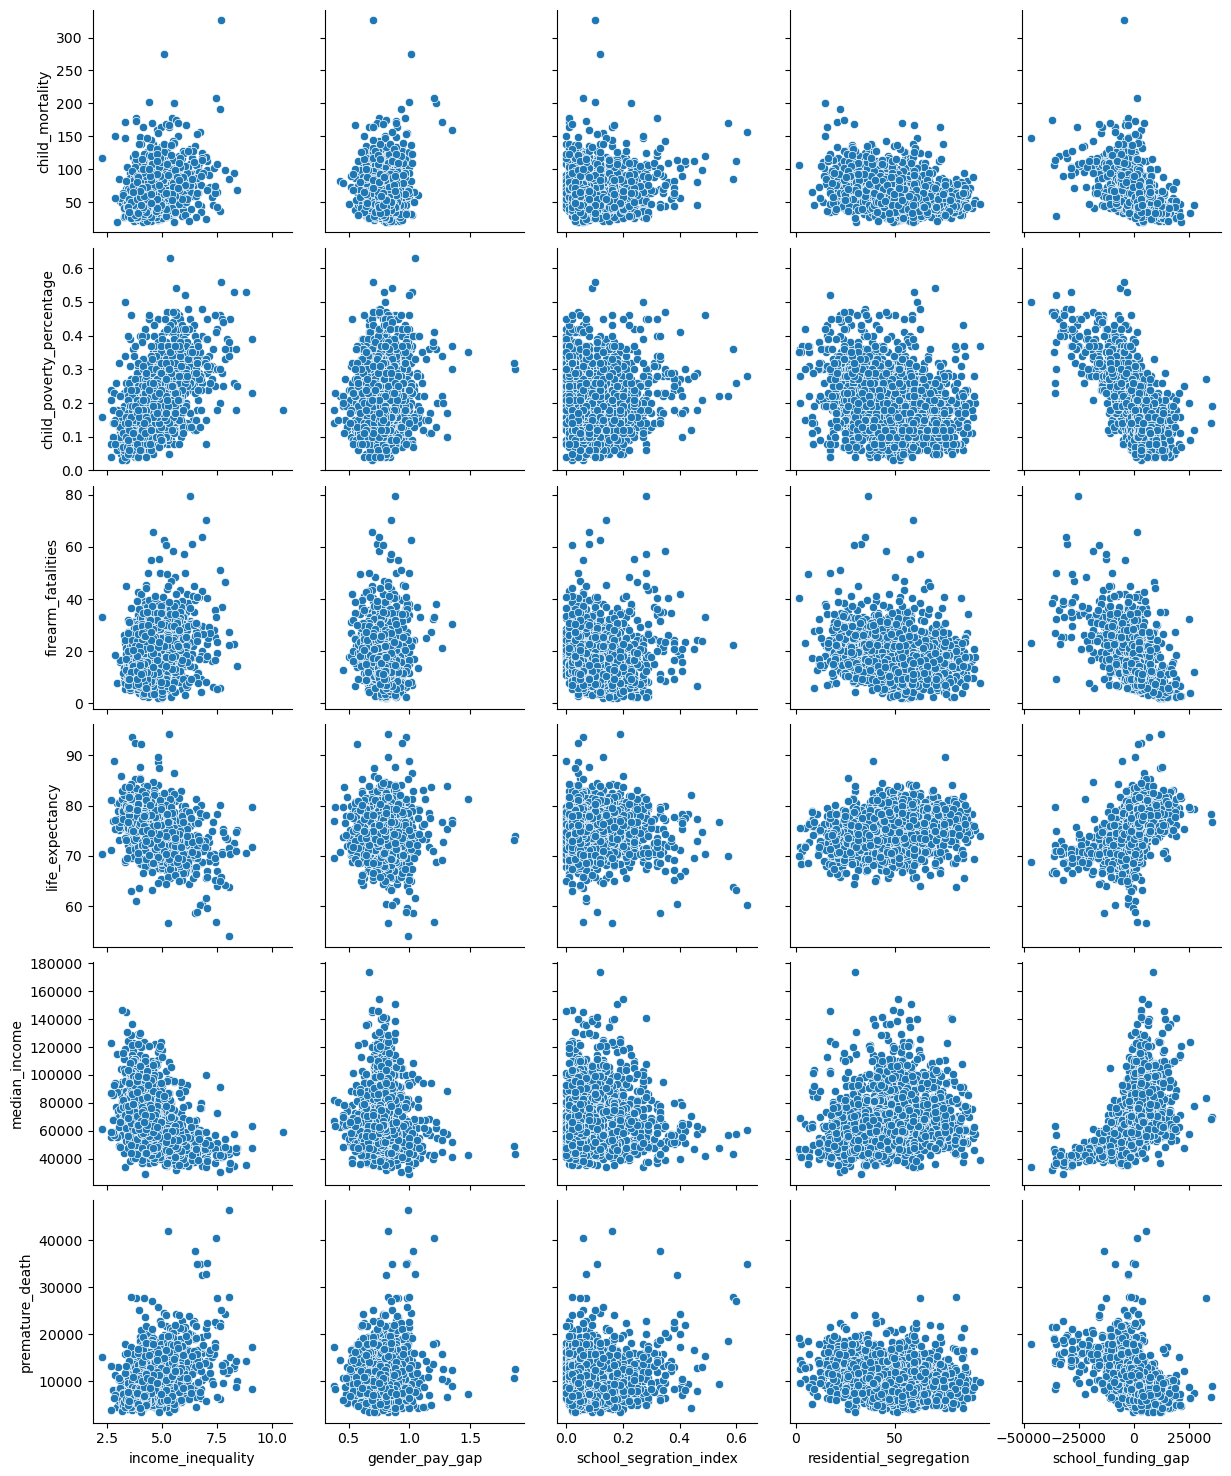

In [232]:
sns.pairplot(counties, 
    x_vars= ['income_inequality', 'gender_pay_gap', 'school_segration_index', 'residential_segregation','school_funding_gap'],
    y_vars= ['child_mortality', 'child_poverty_percentage','firearm_fatalities', 'life_expectancy', 'median_income', 'premature_death'],
    )     

### Distributions

#### Income Inequality

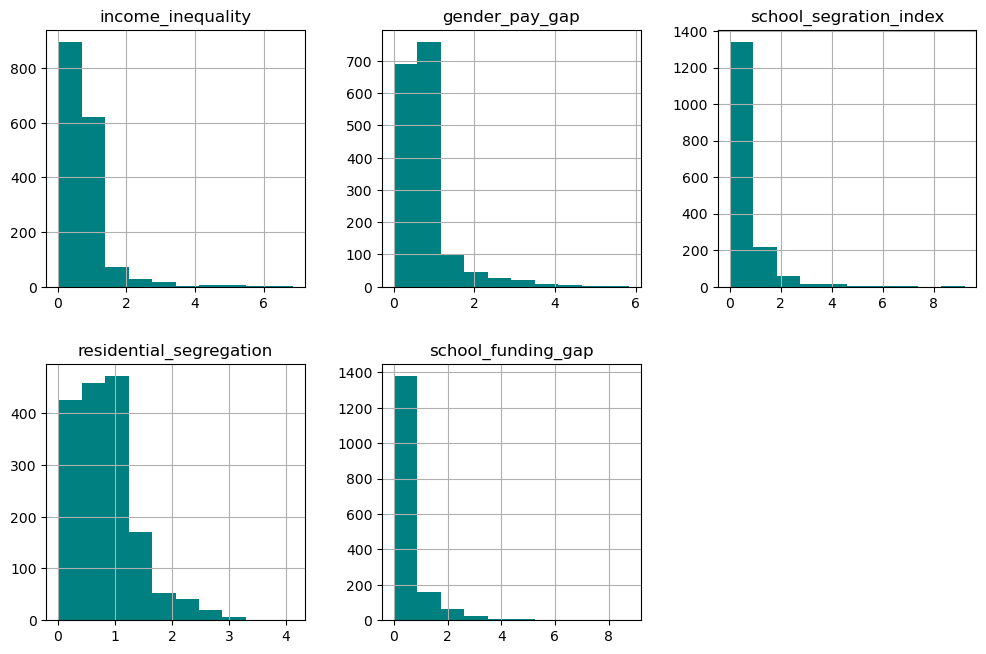

In [238]:
inequity_df = z_counties[inequity_vars]
inequity_df.hist(figsize=(12,12), layout=(3,3), color='teal', ec='black', sharex=False);

**Note**: note normally distributed

#### Social Indicators

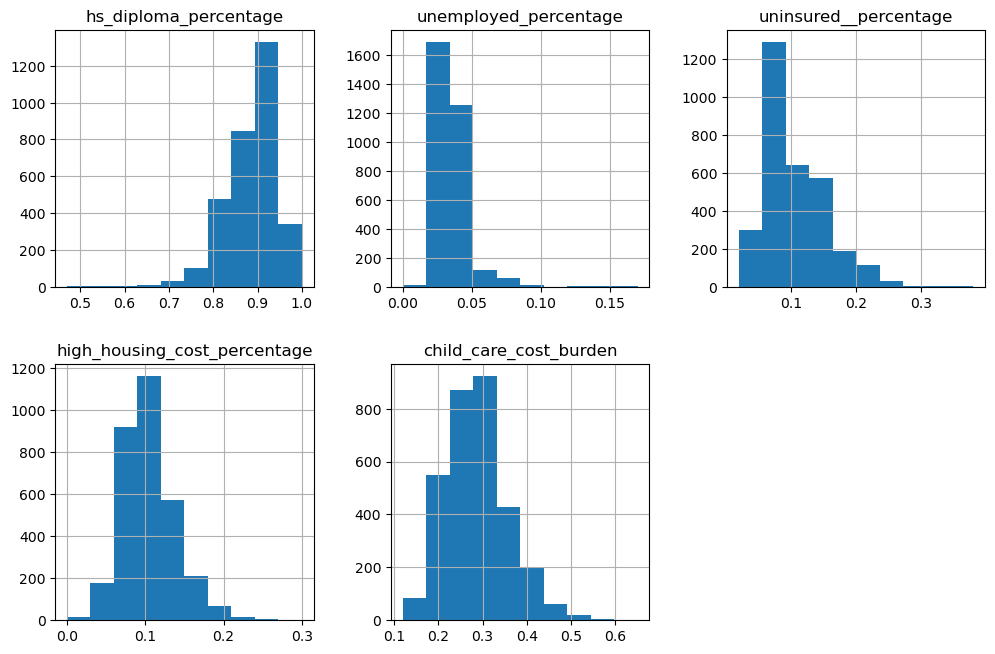

In [239]:
aggregate_outcomes_dist = aggregate_outcomes.drop(columns='population')
aggregate_outcomes_dist.hist(figsize=(12,12), layout=(3,3), sharex=False);

plt.show()

## Regression

In [ ]:
fig, ax = plt.subplots()  
ax.scatter(us_counties_updated['income_inequality'], us_counties_updated['child_mortality'])  
ax.set_xlabel('Income Inequality Index')  
ax.set_ylabel('Child Mortality')  
plt.show()

## Drill down on race

### Pair Plots

In [240]:
race_anlysis = counties_race.copy()
race_anlysis = counties_race.drop(columns=['county_population', 'population_percentage'])

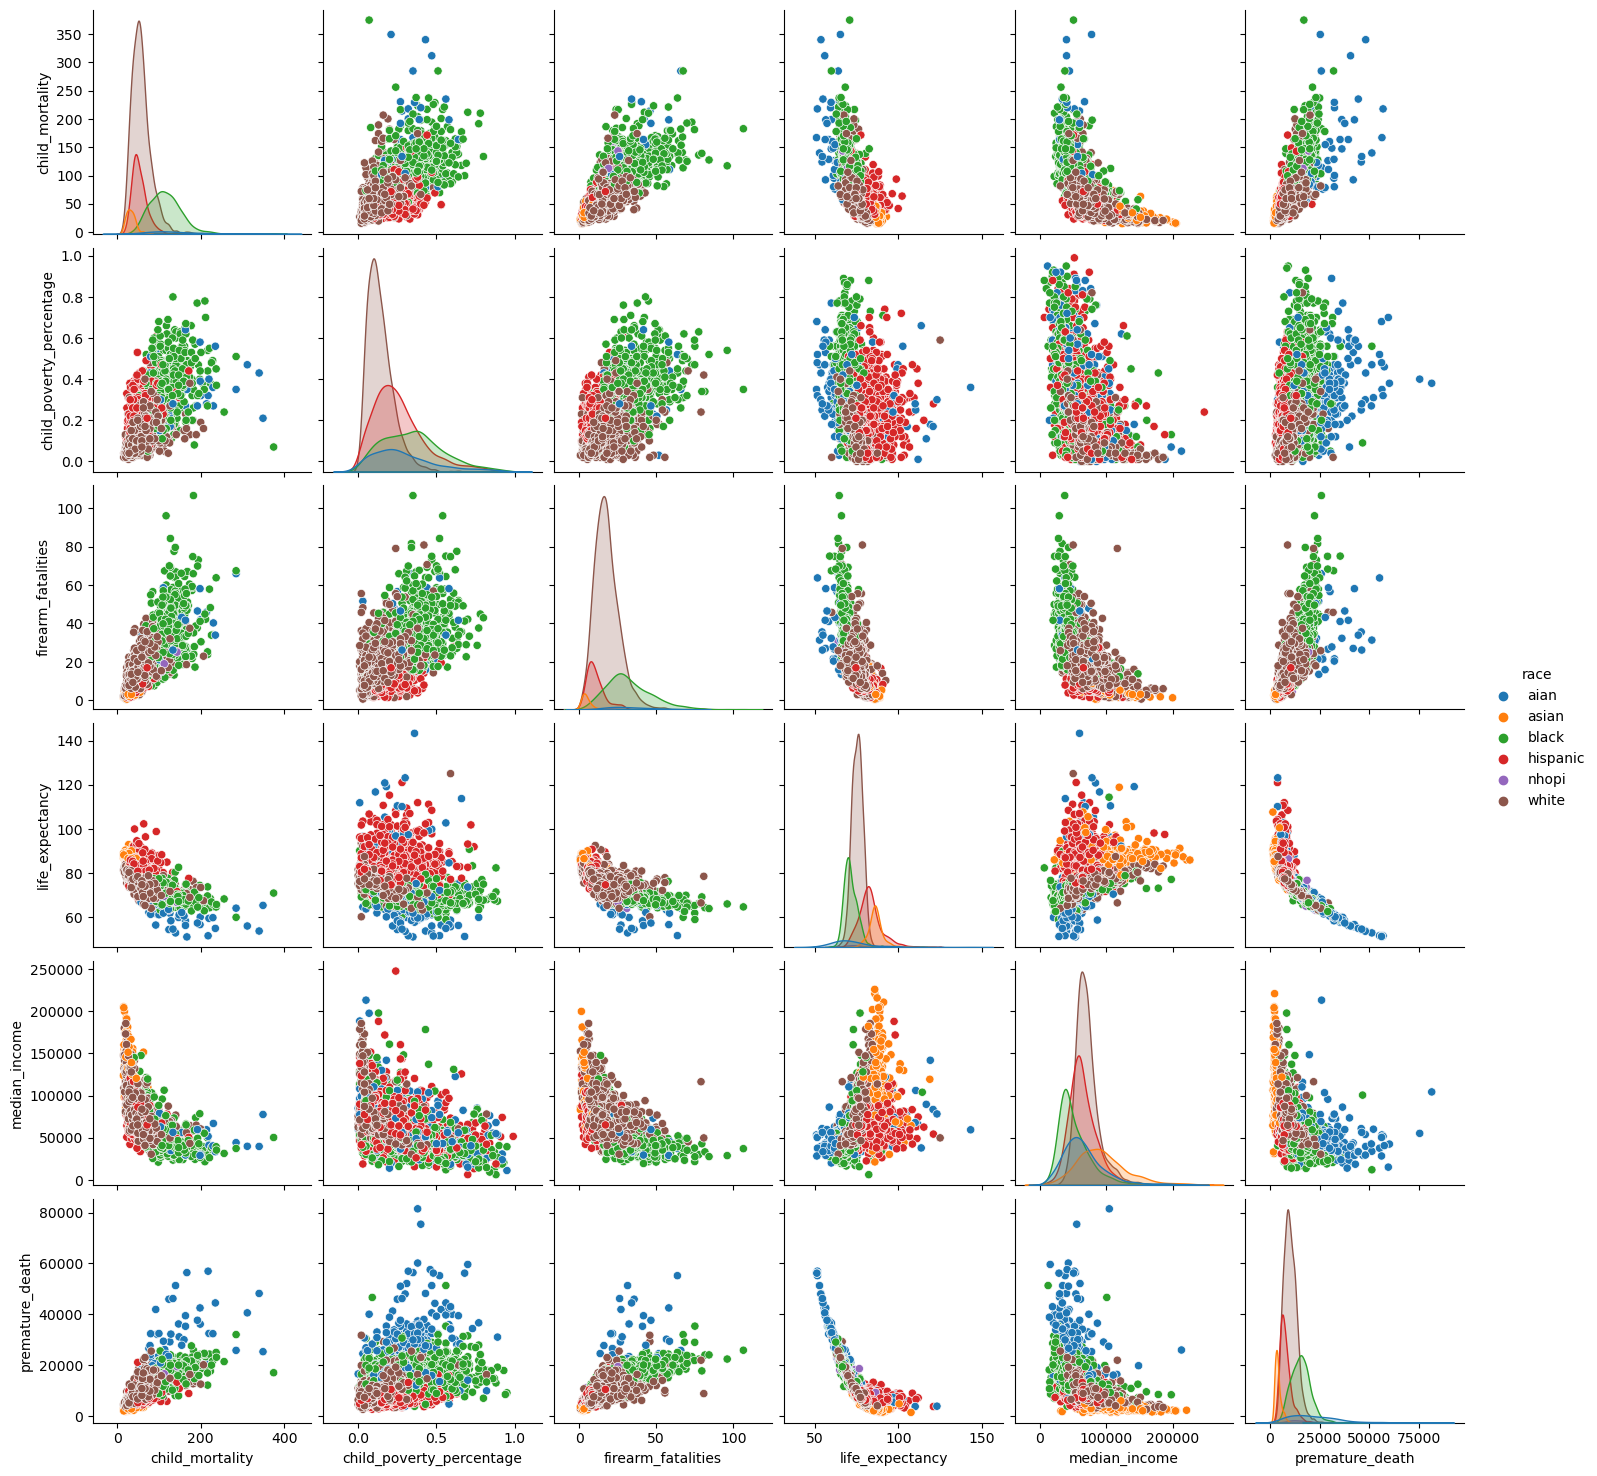

In [241]:
sns.pairplot(race_anlysis, hue='race')

### Comparing distributions between income inequality groupings: 'above_median' and 'below_median'

In [ ]:
print(us_counties_updated['income_inequality'].median())